In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [2]:
import os
os.chdir("/content/gdrive/My Drive/Ece 9039/dataset")

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report,confusion_matrix
import cv2

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier

from keras.utils import to_categorical, plot_model
from keras.applications import DenseNet121
from keras.applications import VGG16
from keras.applications.resnet import ResNet152
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

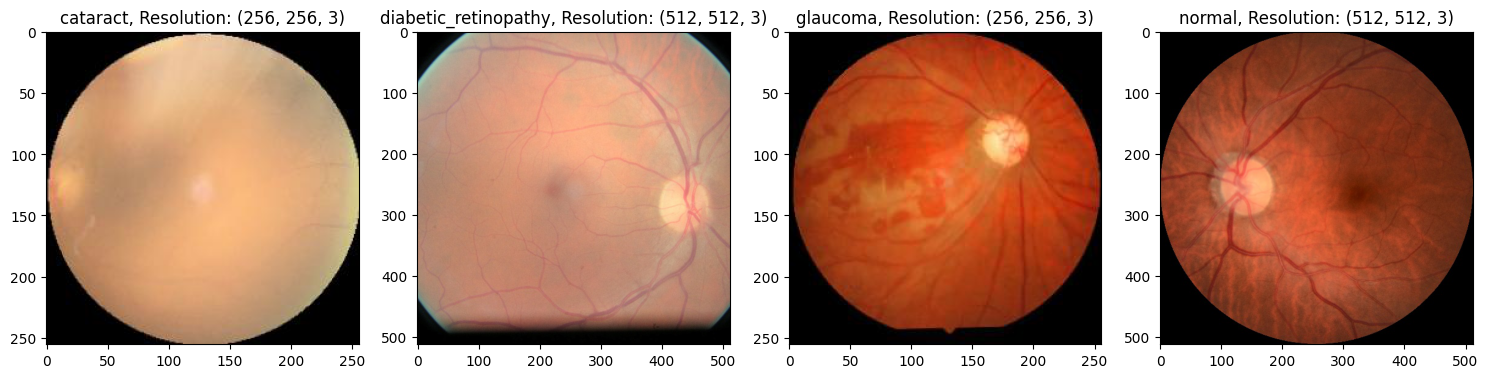

In [3]:
fig, ax = plt.subplots(1,4, figsize=(15,8))
# Cataract Image
cataract_img = plt.imread('./cataract/_1_5346540.jpg')
ax[0].imshow(cataract_img)
ax[0].set_title('cataract, Resolution: {:}'.format(cataract_img.shape))

# Diabetic_retinopathy
diabetic_retinopathy_img = plt.imread('./diabetic_retinopathy/100_left.jpeg')
ax[1].imshow(diabetic_retinopathy_img)
ax[1].set_title('diabetic_retinopathy, Resolution: {:}'.format(diabetic_retinopathy_img.shape))

# Glaucoma Image
glaucoma_img = plt.imread('./glaucoma/_0_4517448.jpg')
ax[2].imshow(glaucoma_img)
ax[2].set_title('glaucoma, Resolution: {:}'.format(glaucoma_img.shape))

# Normal Image
normal_img = plt.imread('./normal/8_left.jpg')
ax[3].imshow(normal_img)
ax[3].set_title('normal, Resolution: {:}'.format(normal_img.shape))

plt.tight_layout()
plt.show()

In [ ]:
def remove_corrupt(path):
    corrupt = 0
    for folder_name in ('glaucoma', 'normal', 'cataract', 'diabetic_retinopathy'):
        folder_path = os.path.join(path, folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()
            if not is_jfif:
                corrupt += 1
                # Drop corrupted image
                os.remove(fpath)
    print(f'Total %d corrupt images dataset: ' % corrupt)
    print('All corrupt images dropped.' + '\n')

remove_corrupt_info = remove_corrupt('./')

In [14]:
dataset_path = os.listdir('./')
print (dataset_path)
print("Types of classes labels found: ", len(dataset_path))

def dataset_info(path_dir):
  label_iamge_info = []

  for item in path_dir: 
    all_image = os.listdir('./' +item+'/')
  # Add them to the list
    
    label_iamge_info.append((item, str(len(all_image))))
  return label_iamge_info

label_iamge_info = dataset_info(dataset_path)

df = pd.DataFrame(data=label_iamge_info, columns=['Labels', 'image_number'])
df.head()

['glaucoma', 'normal', 'cataract', 'diabetic_retinopathy']
Types of classes labels found:  4


,Labels,image_number
0,glaucoma,906
1,normal,1074
2,cataract,938
3,diabetic_retinopathy,1098


In [19]:
train_data = image_dataset_from_directory('./',
                                        seed = 2022, 
                                        image_size=(224, 224),
                                        batch_size = 64,
                                        shuffle=True,
                                        color_mode = 'rgb',
                                        label_mode = 'categorical',
                                        validation_split=0.3, 
                                        subset='training')
# class_names = train_data.class_names
# plt.figure(figsize=(12, 7))
# for images, labels in train_data.take(1):
#   for i in range(6):
#     ax = plt.subplot(2, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

validate_data = image_dataset_from_directory('./',
                                        seed = 2022, 
                                        image_size=(224, 224),
                                        batch_size = 64,
                                        shuffle=True,
                                        color_mode = 'rgb',
                                        label_mode = 'categorical',
                                        validation_split=0.3, 
                                        subset='validation')
# class_names = validate_data.class_names
# plt.figure(figsize=(12, 7))
# for images, labels in validate_data.take(1):
#   for i in range(6):
#     ax = plt.subplot(2, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

val_batches = tf.data.experimental.cardinality(validate_data)
test_data = validate_data.take((2*val_batches) // 3)
validate_data = validate_data.skip((2*val_batches) // 3)

class_names = train_data.class_names


Found 4016 files belonging to 4 classes.
Using 2812 files for training.
Found 4016 files belonging to 4 classes.
Using 1204 files for validation.


In [5]:
train_data = train_data.map(lambda x, y: (x/255, y))
validate_data = validate_data.map(lambda x, y: (x/255, y))
test_data = test_data.map(lambda x, y: (x/255, y))

print(f"# train batchs = {len(train_data)}, # validate batchs = {len(validate_data)}, # test batch = {len(test_data)}")

# train batchs = 44, # validate batchs = 7, # test batch = 12


In [ ]:
# set the image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 64
# create the image data generators for training and validation data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.3)

In [ ]:
def Grid_Search_TL_model(active = 'relu', learning_rate = 0.01, dropout = 0.5):
  densenet = DenseNet121(weights = "imagenet", include_top = False, input_shape=(224,224,3), pooling='avg')

  model = Sequential([
      densenet,
      Dense(512, activation=active),
      Dropout(dropout),
      Dense(256, activation=active),
      Dropout(dropout),
      Dense(4, activation='sigmoid')
  ])
   # Freeze the layers of the pre-trained model
  densenet.trainable = False

  adam = Adam(learning_rate=learning_rate)
  model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

  #we will perform a gridsearch on 3 hidden_neurons and 2 learning_rate
param_grid = dict(active=['relu', 'tanh'],learning_rate = [0.01,0.001,0.0001], dropout = [0.5,0.8])

hp_model = KerasClassifier(build_fn=Grid_Search_TL_model, verbose=0)
#instantiate gridsearch object using 3 fold crossvaliadtion
grid = GridSearchCV(estimator=hp_model, param_grid=param_grid, cv=3,error_score='raise')

# get the training and validation data generators and their corresponding targets
X_train, y_train = train_datagen.flow_from_directory('./', subset='training', target_size=(img_width, img_height), batch_size=batch_size, class_mode='categorical').next()
X_validate, y_validate = train_datagen.flow_from_directory('./', subset='validation', target_size=(img_width, img_height), batch_size=batch_size, class_mode='categorical').next()

grid_result = grid.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs = 1, callbacks=[EarlyStopping(patience=3)])

#determine the best parameter
print(grid_result.best_params_)
print(grid_result.best_score_)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense_5 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 7,041,604
Trainable params: 4,100
Non-trainable params: 7,037,504
_________________________________________________________________


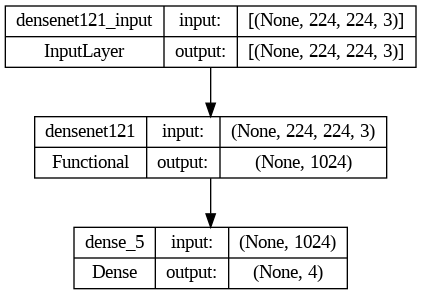

In [12]:
densenet = DenseNet121(weights = "imagenet", include_top = False, input_shape=(224,224,3), pooling='avg')

# Freeze the layers of the pre-trained model
for layer in densenet.layers:
      layer.trainable = False

# densenet.summary()

# Create the model
model = Sequential([
    densenet,
    # Dense(512, activation='relu'),
    # Dropout(0.5),
    # Dense(128, activation='relu'),
    # Dropout(0.5),
    Dense(4, activation='sigmoid')
])
adam = Adam(learning_rate=0.001)
model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

plot_model(model, to_file='DenseNet121-plant.png', show_shapes=True)


Epoch 1/10
44/44 [==============================] - 25s 380ms/step - loss: 0.9829 - accuracy: 0.6184 - val_loss: 0.7101 - val_accuracy: 0.7362
Epoch 2/10
44/44 [==============================] - 20s 425ms/step - loss: 0.6177 - accuracy: 0.7781 - val_loss: 0.5898 - val_accuracy: 0.7982
Epoch 3/10
44/44 [==============================] - 14s 303ms/step - loss: 0.5264 - accuracy: 0.8069 - val_loss: 0.5477 - val_accuracy: 0.7959
Epoch 4/10
44/44 [==============================] - 16s 347ms/step - loss: 0.4802 - accuracy: 0.8240 - val_loss: 0.4978 - val_accuracy: 0.8326
Epoch 5/10
44/44 [==============================] - 15s 326ms/step - loss: 0.4398 - accuracy: 0.8417 - val_loss: 0.4810 - val_accuracy: 0.8280
Epoch 6/10
44/44 [==============================] - 15s 307ms/step - loss: 0.4121 - accuracy: 0.8528 - val_loss: 0.4381 - val_accuracy: 0.8647
Epoch 7/10
44/44 [==============================] - 16s 338ms/step - loss: 0.3949 - accuracy: 0.8595 - val_loss: 0.4405 - val_accuracy: 0.8486

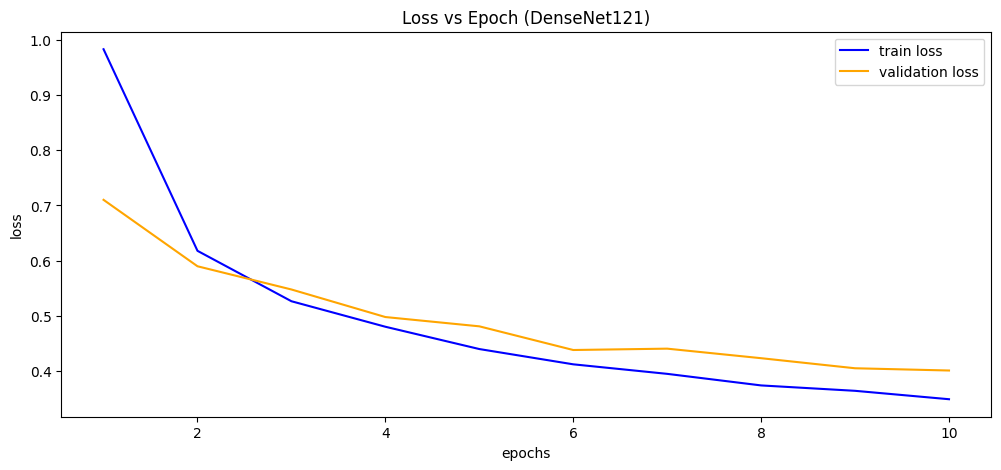

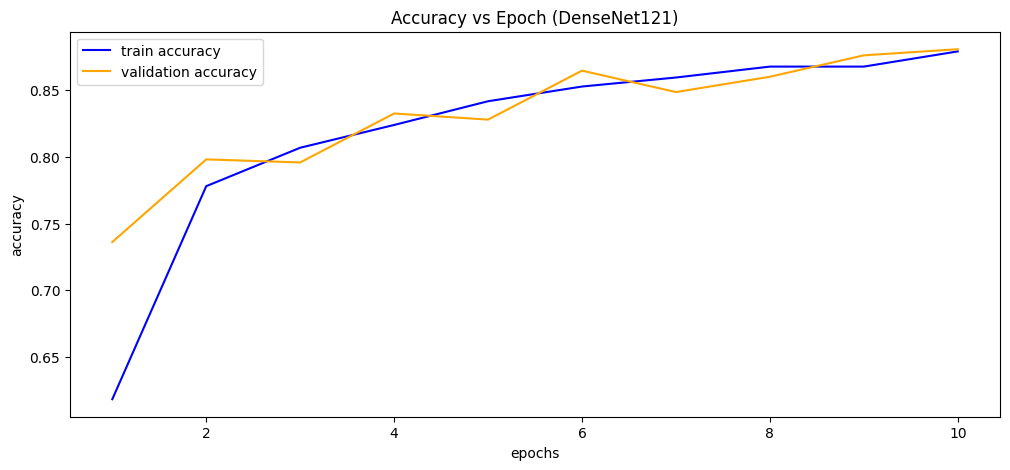

In [13]:
# pick loss, val_loss, accuracy and val_accuracy for comparsion
hist = model.fit(train_data, validation_data = validate_data, epochs = 10, verbose = 1, batch_size=64)
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

print(train_loss)
print(train_accuracy)
print(val_loss)
print(val_accuracy)

# loss for each iteration, and make a plot of iterations/epochs vs loss
epochs = list(range(1,11))
plt.figure(figsize=(9,3))
plt.plot(epochs,train_loss, color='blue', label='train loss')
plt.plot(epochs,val_loss, color='orange', label='validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss vs Epoch (DenseNet121)")
plt.legend(loc='best')
plt.show()


plt.figure(figsize=(9,3))
plt.plot(epochs,train_accuracy, color='blue', label='train accuracy')
plt.plot(epochs,val_accuracy, color='orange', label='validation accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Accuracy vs Epoch (DenseNet121)')
plt.legend(loc='best')
plt.show()


In [ ]:
loss, accuracy = model.evaluate(test_data, verbose=0)
print('Test accuracy: %.2f%%' % (accuracy * 100))

In [ ]:
def Grid_Search_TL_model(active = 'relu', learning_rate = 0.01, dropout = 0.5):
  vgg16 = VGG16(weights = "imagenet", include_top = False, input_shape=(224,224,3), pooling='avg')

  model = Sequential([
      vgg16,
      Dense(512, activation=active),
      Dropout(dropout),
      Dense(256, activation=active),
      Dropout(dropout),
      Dense(4, activation='sigmoid')
  ])
   # Freeze the layers of the pre-trained model
  for layer in vgg16.layers:
      layer.trainable = False

  adam = Adam(learning_rate=learning_rate)
  model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

  #we will perform a gridsearch on 3 hidden_neurons and 2 learning_rate
param_grid = dict(active=['relu', 'tanh'],learning_rate = [0.01,0.001,0.0001], dropout = [0.5,0.8])

hp_model = KerasClassifier(build_fn=Grid_Search_TL_model, verbose=0)
#instantiate gridsearch object using 3 fold crossvaliadtion
grid = GridSearchCV(estimator=hp_model, param_grid=param_grid, cv=3,error_score='raise')

# get the training and validation data generators and their corresponding targets
X_train, y_train = train_datagen.flow_from_directory('./', subset='training', target_size=(img_width, img_height), batch_size=batch_size, class_mode='categorical').next()
X_validate, y_validate = train_datagen.flow_from_directory('./', subset='validation', target_size=(img_width, img_height), batch_size=batch_size, class_mode='categorical').next()

grid_result = grid.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs = 1, callbacks=[EarlyStopping(patience=3)])

#determine the best parameter
print(grid_result.best_params_)
print(grid_result.best_score_)

In [ ]:
vgg16 = VGG16(weights = "imagenet", include_top = False, input_shape=(224,224,3), pooling='avg')

# Freeze the layers of the pre-trained model
for layer in vgg16.layers:
    layer.trainable = False

# vgg16.summary()

# Create the model
model = Sequential([
    vgg16,
    # Dense(512, activation='relu'),
    # Dropout(0.8),
    # Dense(256, activation='relu'),
    # Dropout(0.8),
    Dense(4, activation='sigmoid')
])
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

plot_model(model, to_file='VGG16-plant.png', show_shapes=True)

Epoch 1/10
44/44 [==============================] - 343s 8s/step - loss: 1.3480 - accuracy: 0.3517 - val_loss: 1.2645 - val_accuracy: 0.5573
Epoch 2/10
44/44 [==============================] - 16s 342ms/step - loss: 1.1972 - accuracy: 0.5996 - val_loss: 1.1476 - val_accuracy: 0.5986
Epoch 3/10
44/44 [==============================] - 18s 376ms/step - loss: 1.0943 - accuracy: 0.6643 - val_loss: 1.0589 - val_accuracy: 0.6422
Epoch 4/10
44/44 [==============================] - 16s 347ms/step - loss: 1.0181 - accuracy: 0.6860 - val_loss: 1.0139 - val_accuracy: 0.6399
Epoch 5/10
44/44 [==============================] - 16s 347ms/step - loss: 0.9604 - accuracy: 0.7027 - val_loss: 0.9718 - val_accuracy: 0.6560
Epoch 6/10
44/44 [==============================] - 16s 349ms/step - loss: 0.9137 - accuracy: 0.7180 - val_loss: 0.9230 - val_accuracy: 0.6560
Epoch 7/10
44/44 [==============================] - 19s 383ms/step - loss: 0.8779 - accuracy: 0.7216 - val_loss: 0.8708 - val_accuracy: 0.6972
E

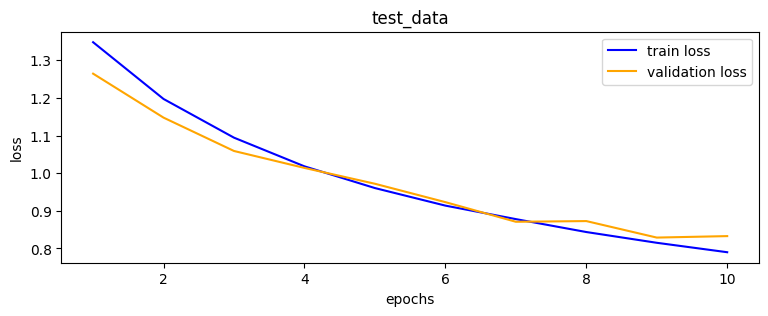

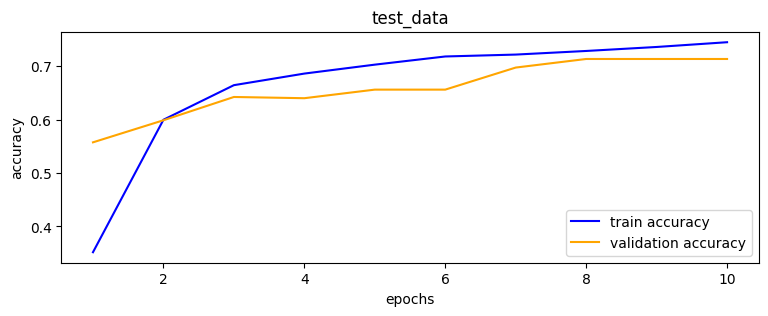

In [11]:
# pick loss, val_loss, accuracy and val_accuracy for comparsion
hist = model.fit(train_data, validation_data = validate_data, epochs = 10, verbose = 1, batch_size=64)
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

print(train_loss)
print(train_accuracy)
print(val_loss)
print(val_accuracy)

# loss for each iteration, and make a plot of iterations/epochs vs loss
epochs = list(range(1,11))
plt.figure(figsize=(9,3))
plt.plot(epochs,train_loss, color='blue', label='train loss')
plt.plot(epochs,val_loss, color='orange', label='validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss vs Epoch (VGG16)")
plt.legend(loc='best')
plt.show()


plt.figure(figsize=(9,3))
plt.plot(epochs,train_accuracy, color='blue', label='train accuracy')
plt.plot(epochs,val_accuracy, color='orange', label='validation accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Accuracy vs Epoch (VGG16)')
plt.legend(loc='best')
plt.show()

In [12]:
loss, accuracy = model.evaluate(test_data, verbose=0)
print('Test accuracy: %.2f%%' % (accuracy * 100))

Test accuracy: 72.01%


In [ ]:
def Grid_Search_TL_model(active = 'relu', learning_rate = 0.01, dropout = 0.5):
  resnet152 = ResNet152(weights = "imagenet", include_top = False, input_shape=(224,224,3), pooling='avg')

  model = Sequential([
      resnet152,
      Dense(512, activation=active),
      Dropout(dropout),
      Dense(256, activation=active),
      Dropout(dropout),
      Dense(4, activation='sigmoid')
  ])
   # Freeze the layers of the pre-trained model
  for layer in resnet152.layers:
      layer.trainable = False

  adam = Adam(learning_rate=learning_rate)
  model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

  #we will perform a gridsearch on 3 hidden_neurons and 2 learning_rate
param_grid = dict(active=['relu', 'tanh'],learning_rate = [0.01,0.001,0.0001], dropout = [0.5,0.8])

hp_model = KerasClassifier(build_fn=Grid_Search_TL_model, verbose=0)
#instantiate gridsearch object using 3 fold crossvaliadtion
grid = GridSearchCV(estimator=hp_model, param_grid=param_grid, cv=3,error_score='raise')

# get the training and validation data generators and their corresponding targets
X_train, y_train = train_datagen.flow_from_directory('./', subset='training', target_size=(img_width, img_height), batch_size=batch_size, class_mode='categorical').next()
X_validate, y_validate = train_datagen.flow_from_directory('./', subset='validation', target_size=(img_width, img_height), batch_size=batch_size, class_mode='categorical').next()

grid_result = grid.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs = 1, callbacks=[EarlyStopping(patience=3)])

#determine the best parameter
print(grid_result.best_params_)
print(grid_result.best_score_)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 dense_3 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 58,379,140
Trainable params: 8,196
Non-trainable params: 58,370,944
_________________________________________________________________


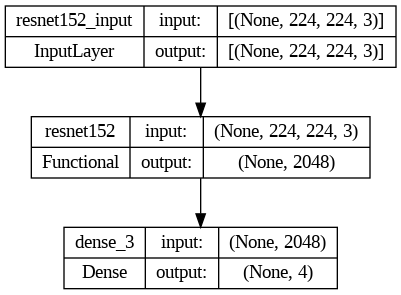

In [34]:
resnet152 = ResNet152(weights = "imagenet", include_top = False, input_shape=(224,224,3), pooling='avg')


# Freeze the layers of the pre-trained model
for layer in resnet152.layers:
    layer.trainable = False

# resnet152.summary()

# Create the model
model = Sequential([
    resnet152,
    # Dense(512, activation='relu'),
    # Dropout(0.5),
    # Dense(256, activation='relu'),
    # Dropout(0.5),
    Dense(4, activation='sigmoid')
])
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

plot_model(model, to_file='ResNet152-plant.png', show_shapes=True)

Epoch 1/10
44/44 [==============================] - 45s 726ms/step - loss: 0.7618 - accuracy: 0.6814 - val_loss: 0.5922 - val_accuracy: 0.7706
Epoch 2/10
44/44 [==============================] - 26s 572ms/step - loss: 0.4735 - accuracy: 0.8115 - val_loss: 0.4662 - val_accuracy: 0.8394
Epoch 3/10
44/44 [==============================] - 26s 572ms/step - loss: 0.4019 - accuracy: 0.8492 - val_loss: 0.4135 - val_accuracy: 0.8532
Epoch 4/10
44/44 [==============================] - 27s 581ms/step - loss: 0.3584 - accuracy: 0.8691 - val_loss: 0.4695 - val_accuracy: 0.8257
Epoch 5/10
44/44 [==============================] - 27s 586ms/step - loss: 0.3312 - accuracy: 0.8784 - val_loss: 0.3889 - val_accuracy: 0.8693
Epoch 6/10
44/44 [==============================] - 27s 587ms/step - loss: 0.3101 - accuracy: 0.8869 - val_loss: 0.3881 - val_accuracy: 0.8624
Epoch 7/10
44/44 [==============================] - 27s 590ms/step - loss: 0.2893 - accuracy: 0.8962 - val_loss: 0.3515 - val_accuracy: 0.8670

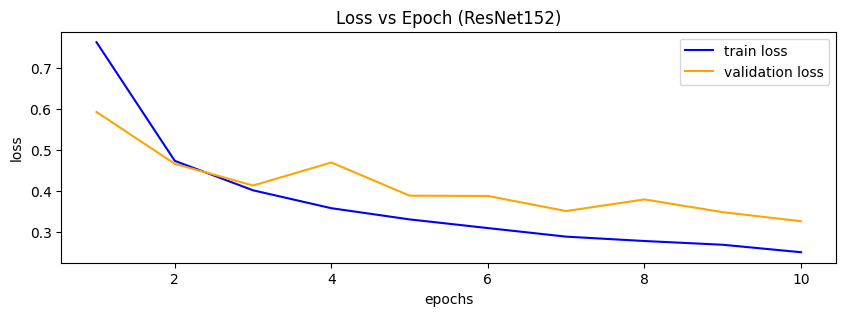

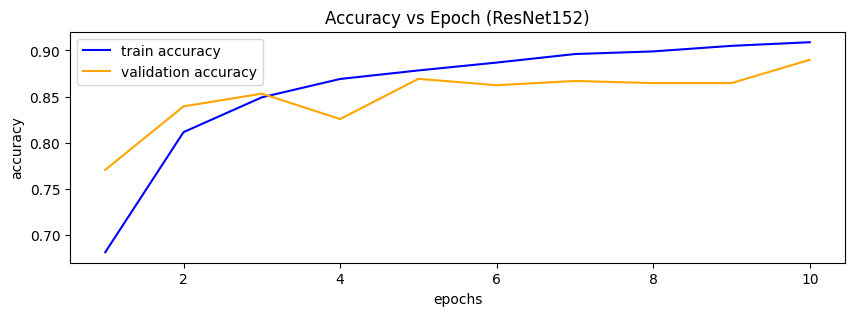

In [35]:
# pick loss, val_loss, accuracy and val_accuracy for comparsion
hist = model.fit(train_data, validation_data = validate_data, epochs = 10, verbose = 1, batch_size=64)
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

print(train_loss)
print(train_accuracy)
print(val_loss)
print(val_accuracy)

# loss for each iteration, and make a plot of iterations/epochs vs loss
epochs = list(range(1,11))
plt.figure(figsize=(10,3))
plt.plot(epochs,train_loss, color='blue', label='train loss')
plt.plot(epochs,val_loss, color='orange', label='validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss vs Epoch (ResNet152)")
plt.legend(loc='best')
plt.show()


plt.figure(figsize=(10,3))
plt.plot(epochs,train_accuracy, color='blue', label='train accuracy')
plt.plot(epochs,val_accuracy, color='orange', label='validation accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Accuracy vs Epoch (ResNet152)')
plt.legend(loc='best')
plt.show()

In [36]:
loss, accuracy = model.evaluate(test_data, verbose=0)
print('Test accuracy: %.2f%%' % (accuracy * 100))

Test accuracy: 88.02%
